Name: Ayse Irmak Ercevik

ID: 181104003

Course: BIL570 /BIL470

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from itertools import cycle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import gzip
import pickle
import shutil

from logreg import LogisticRegression

# Veri Setinin Yüklenmesi:

Aşağıdaki adreslerden .gz uzantılı veri seti yüklenmiştir.
https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz

In [3]:
filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def save_mnist():
    with gzip.open("train-images-idx3-ubyte.gz",'rb') as f_in:
        with open("train-images.idx3-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    with gzip.open("t10k-images-idx3-ubyte.gz",'rb') as f_in:
        with open("t10k-images.idx3-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    with gzip.open("train-labels-idx1-ubyte.gz",'rb') as f_in:
        with open("train-labels.idx1-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    with gzip.open("t10k-labels-idx1-ubyte.gz",'rb') as f_in:
        with open("t10k-labels.idx1-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
            
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"];

def load_list():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"].tolist(), mnist["training_labels"].tolist(), mnist["test_images"].tolist(), mnist["test_labels"].tolist()
init();

Save complete.


# Exploratory Data Analysis (EDA)

EDA için yüklenen veri setinde bazı değişiklikler yapılmıştır ve uygun .cvs uzantılı dosyalara çevrilmiştir.

In [4]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("train-images.idx3-ubyte", "train-labels.idx1-ubyte",
        "mnist_train.csv", 60000)
convert("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte",
        "mnist_test.csv", 10000)
df_orig_train = pd.read_csv('mnist_train.csv');
df_orig_test = pd.read_csv('mnist_test.csv');

df_orig_train.rename(columns={'5':'label'}, inplace=True)
df_orig_test.rename(columns={'7':'label'}, inplace=True);
df_orig_train.to_csv('mnist_train_final.csv', index=False)
df_orig_test.to_csv('mnist_test_final.csv', index=False)

Düzenlenen train ve test verileri ayrı iki .csv uzntılı dosyada tutulmuştur.

### Düzenlenen Veri Setinin Okunması

In [5]:
df_orig_train = pd.read_csv('mnist_train_final.csv')
df_orig_test = pd.read_csv('mnist_test_final.csv')

### Veri seti Özeti

Veri setinin genel bilgiler aşağıda verilmiştir.

Toplam veri setinin yaklaşık %86'sı eğitim içn geri kalan %14'ü ise test için kullanılmıştır.

#### Eğitim için kullanılması planlanan veri grubunun bilgisi:

In [6]:
display(df_orig_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59999 entries, 0 to 59998
Columns: 785 entries, label to 0.617
dtypes: int64(785)
memory usage: 359.3 MB


None

In [7]:
display(df_orig_train.head())

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
display(df_orig_train.shape)

(59999, 785)

In [9]:
nan = df_orig_train.isnull().sum();
display(nan[nan != 0]);
display("Eğitim verisinde herhangi bir NULL değer bulunmamaktadır");

Series([], dtype: int64)

'Eğitim verisinde herhangi bir NULL değer bulunmamaktadır'

Yukarıdanda anlaşılacağı üzere train veri grubu (28x28) pikselden oluşan 60000 görüntüden oluşmaktadır.

Eğitim veri grubundan rastgele seçilmiş 40 verinin görüntüsü ağaşıda verilmiştir

Rastgele seçilen el yazı görüntüleri: [1 2 3 1 8 5 3 7 6 4 6 5 3 6 2 5 6 6 6 9 9 7 5 3 3 2 0 8 7 7 5 5 2 4 6 2 1
 3 2 0]


C:\Users\begon\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


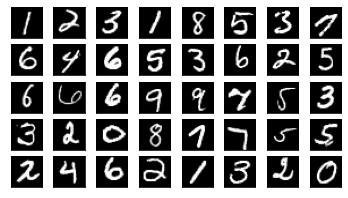

In [10]:
def display_digits(N):    
    images = np.random.randint(low=0, high=60001, size=N).tolist()
    
    subset_images = df_orig_train.iloc[images,:]
    subset_images.index = range(1, N+1)
    print("Rastgele seçilen el yazı görüntüleri:", subset_images['label'].values)
    subset_images.drop(columns=['label'], inplace=True)

    for i, row in subset_images.iterrows():
        plt.subplot((N//8)+1, 8, i)
        pixels = row.values.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.xticks([])
        plt.yticks([])
   
    plt.show()

    return ""
display_digits(40);

Eğitimde bulunan görüntülerin ait oldukları rakamlara göre dağılımı ve istatiksel analizleri aşağıda verilmiştir.

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
count,59999.0,59999.0,59999.0,59999.0,59999.0,59999.0,59999.0,59999.0,59999.0,59999.0,...,59999.000000,59999.000000,59999.000000,59999.000000,59999.000000,59999.000000,59999.0,59999.0,59999.0,59999.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200437,0.088868,0.045634,0.019284,0.015117,0.002000,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042522,3.956222,2.839868,1.686784,1.678297,0.346603,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


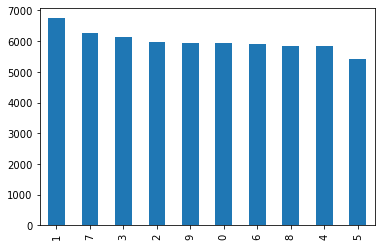

In [11]:
subset_pixels = df_orig_train.iloc[:, 1:];
display(subset_pixels.describe());
_ = df_orig_train['label'].value_counts().plot(kind='bar')
plt.show();

#### Test için kullanılması planlanan veri grubunun bilgisi:

In [12]:
display(df_orig_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Columns: 785 entries, label to 0.667
dtypes: int64(785)
memory usage: 59.9 MB


None

In [13]:
display(df_orig_test.head());

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
display(df_orig_test.shape)

(9999, 785)

In [15]:
nan = df_orig_test.isnull().sum();
display(nan[nan != 0]);
display("Test verisinde herhangi bir NULL değer bulunmamaktadır");

Series([], dtype: int64)

'Test verisinde herhangi bir NULL değer bulunmamaktadır'

Yukarıdanda anlaşılacağı üzere train veri grubu (28x28) pikselden oluşan 10000 görüntüden oluşmaktadır.

Test veri grubundan rastgele seçilmiş 40 verinin görüntüsü ağaşıda verilmiştir

Rastgele seçilen el yazı görüntüleri: [9 9 1 8 8 4 6 9 9 8 2 4 8 4 6 1 5 2 2 5 4 9 8 3 3 1 3 5 2 1 6 7 4 5 9 2 5
 3 6 5]


C:\Users\begon\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


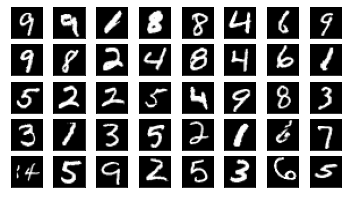

In [16]:
def display_digits(N):    
  
    images = np.random.randint(low=0, high=10001, size=N).tolist()
    
    subset_images = df_orig_test.iloc[images,:]
    subset_images.index = range(1, N+1)
    print("Rastgele seçilen el yazı görüntüleri:", subset_images['label'].values)
    subset_images.drop(columns=['label'], inplace=True)

    for i, row in subset_images.iterrows():
        plt.subplot((N//8)+1, 8, i)
        pixels = row.values.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

    return ""

display_digits(40);

Test verisinde bulunan görüntülerin ait oldukları rakamlara göre dağılımı ve istatiksel analizleri aşağıda verilmiştir.

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
count,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179318,0.163616,0.052605,0.000600,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.674433,5.736359,2.420125,0.060003,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,156.000000,6.000000,0.0,0.0,0.0,0.0,0.0,0.0


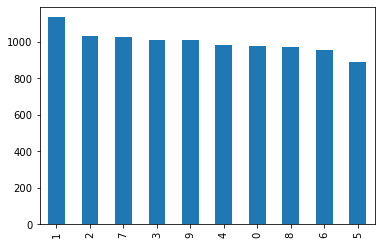

In [17]:
subset_pixels = df_orig_test.iloc[:, 1:];
display(subset_pixels.describe());
_ = df_orig_test['label'].value_counts().plot(kind='bar')
plt.show()

# Veri ön işleme

Test ve Eğitim veri gruplarındaki, 28x28 pikselden oluşan görüntülerin piksel sütunları ile görüntülerin ait olduğu rakamı belirten etiket sütünu gruplandırılmıştır.

In [18]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"];
X_train_np, y_train_np, X_test_np, y_test_np =load(); 
print ("Train veri grubundaki görüntü pikselleri ile hedef değerlerinin ayrılması:");
print("X_train:")
print(X_train_np.shape);
print("y_train:")
print(y_train_np.shape);

print ("Test veri grubundaki görüntü pikselleri ile hedef değerlerinin ayrılması:");
print("X_test:")
print(X_test_np.shape);
print("y_test:")
print(y_test_np.shape);

Train veri grubundaki görüntü pikselleri ile hedef değerlerinin ayrılması:
X_train:
(60000, 784)
y_train:
(60000,)
Test veri grubundaki görüntü pikselleri ile hedef değerlerinin ayrılması:
X_test:
(10000, 784)
y_test:
(10000,)


Aşağıda örnek bir X_trian görüntüsi verilmştir.

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

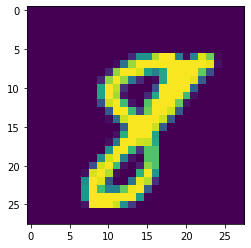

In [19]:
display(X_train_np[55]);
plt.imshow(np.reshape(X_train_np[55],(28,28)))
plt.show()

Aşağıda örnek bir X_test görüntüsü verilmiştir:

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 132
 214 253 254 253 203 162  41   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 102 142 203 203 253 252 253 252 151  70   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 254 253 244 203
 142 102  82   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 172 252 203   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  21 223
 234  30   0   0   0   0   0   0   0   0   0   0   

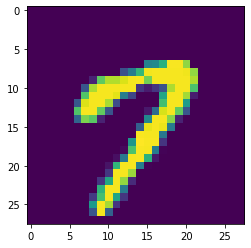

In [20]:
print(X_test_np[15]);
plt.imshow(np.reshape(X_train_np[15],(28,28)))
plt.show()

Yukarıdaki iki gruba ait görüntülerden anlaşılacağı üzere görüntüler 0-255 yoğunluk değerine sahip gri seviyeli görüntülerdir.
Bu görüntülerin 0-1 intensity seviyesine sahip siyah beyaz görüntülere çevrilmesi gerekmektedir. 

In [21]:
X_train_np=X_train_np/255;
X_test_np=X_test_np/255;


Yukarıda veri analizinde ve  veri ön işlemsinde kulanılan Numpy objesi gruplar, logreg.py dosyasına girdi olarak verileceği için python list yapısına çevrilmiştir.

In [22]:
X_train=X_train_np.tolist();
y_train=y_train_np.tolist();
X_test=X_test_np.tolist();
y_test=y_test_np.tolist();

# Logistic Regresyon Modelinin Eğitilmesi

Modelin parametrelerinden;
öğrenme oranı=0.01
iterasyon sayısı=15 ve
batch_size (her iterasyonda kullanılan veri sayısı) =100
seçilmiştir.

In [23]:
lr=LogisticRegression(0.01,15,100);

In [24]:
lr.fit(X_train,y_train);

Epoch 1, Batch 0, Loss 239.37
Epoch 1, Batch 100, Loss 159.98
Epoch 1, Batch 200, Loss 125.77
Epoch 1, Batch 300, Loss 109.47
Epoch 1, Batch 400, Loss 95.01
Epoch 1, Batch 500, Loss 77.09
Train loss: 
45612.065356499596
Train Accuracy: 
0.8336666666666667
Epoch 2, Batch 0, Loss 75.45
Epoch 2, Batch 100, Loss 65.52
Epoch 2, Batch 200, Loss 69.44
Epoch 2, Batch 300, Loss 66.39
Epoch 2, Batch 400, Loss 60.90
Epoch 2, Batch 500, Loss 59.55
Train loss: 
35333.11368182796
Train Accuracy: 
0.85855
Epoch 3, Batch 0, Loss 58.23
Epoch 3, Batch 100, Loss 59.42
Epoch 3, Batch 200, Loss 54.94
Epoch 3, Batch 300, Loss 57.21
Epoch 3, Batch 400, Loss 46.68
Epoch 3, Batch 500, Loss 50.52
Train loss: 
31172.355851529075
Train Accuracy: 
0.86885
Epoch 4, Batch 0, Loss 45.13
Epoch 4, Batch 100, Loss 50.79
Epoch 4, Batch 200, Loss 50.32
Epoch 4, Batch 300, Loss 49.10
Epoch 4, Batch 400, Loss 59.94
Epoch 4, Batch 500, Loss 40.05
Train loss: 
28749.18493175004
Train Accuracy: 
0.8758166666666667
Epoch 5, Bat

# Test Değerlerinin Tahmin Edilmesi

In [27]:
yhat = lr.predict(X_test)

# Eğitim Değerlerinin Tahmin Edilmesi

In [28]:
xhat = lr.predict(X_train)

### Tahmin Edilen Test Değerleri ile Beklenen Test Değerlerinin Karşılaştırması 

In [33]:
print("Beklenen Test Sınıfı Değerleri:")
print(y_test[0:100]);
print("Tahmin Değerleri:")
print(yhat[0:100]);

Beklenen Test Sınıfı Değerleri:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
Tahmin Değerleri:
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 3, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 2, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]


### Tahmin Edilen Eğitim Değerleri ile Beklenen Eğitim Değerlerinin Karşılaştırması 

In [34]:
print("Beklenen Eğitim Sınıfı Değerleri:")
print(y_train[0:600]);
print("Tahmin Değerleri:")
print(xhat[0:600]);

Beklenen Eğitim Sınıfı Değerleri:
[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7, 9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8, 7, 6, 0, 9, 7, 5, 7, 2, 1, 1, 6, 8, 9, 4, 1, 5, 2, 2, 9, 0, 3,

# Results

In [35]:
y_pred2 = pd.Series(yhat);
y_test2 = pd.Series(y_test);

### Test Verilerinin Confusion Matriksi 

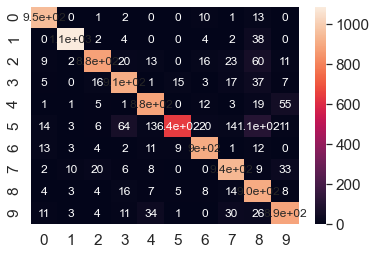

In [36]:
mt=metrics.confusion_matrix(y_test2, y_pred2)
df_cm = pd.DataFrame(mt, range(10), range(10))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### Eğitim Verilerinin Confusion Matriksi 

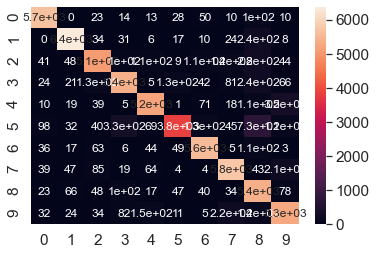

In [37]:
x_pred2 = pd.Series(xhat);
x_test2 = pd.Series(y_train);
mt=metrics.confusion_matrix(x_test2, x_pred2)
df_cm = pd.DataFrame(mt, range(10), range(10))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()


### F1-Score

In [38]:
f1=metrics.f1_score(y_test2, y_pred2,average='weighted');
print("F1-Score Test:")
print(f1);
f2=metrics.f1_score(x_test2, x_pred2,average='weighted');
print("F1-Score Train:")
print(f2);

F1-Score Test:
0.8988175930531688
F1-Score Train:
0.8927050218037105


### Accuracy

In [39]:
accuracy= metrics.accuracy_score(y_test2, y_pred2);
print("Accuracy Test")
print(accuracy);
accuracy2= metrics.accuracy_score(x_test2, x_pred2);
print("Accuracy Train")
print(accuracy2);

Accuracy Test
0.8988
Accuracy Train
0.8926833333333334


### Precision

In [40]:
precision=metrics.precision_score(y_test2, y_pred2, average='weighted');
print("Precision Test:")
print(precision);
precision2=metrics.precision_score(x_test2, x_pred2, average='weighted');
print("Precision Train:")
print(precision2);

Precision Test:
0.9044740269242664
Precision Train:
0.8978696150945125


### Recal

In [41]:
recall=metrics.recall_score(y_test2, y_pred2,average='weighted');
print("Recall Test:")
print(recall);
recall2=metrics.recall_score(x_test2, x_pred2,average='weighted');
print("Recall Train:")
print(recall2)

Recall Test:
0.8988
Recall Train:
0.8926833333333334


Eğitim başarımın 4 kriter içinde yaklaşık %90'lık başarım gösterdiği gözlemlenmiştir. %100'e yakın bir başarım için iterasyon sayısı arttırılabilir ya da  batch_size arttırabilir.

4 farklı başarım kriterinden de görüldüğü üzere test verisinin başarımı göz ardı edilebilecek şekilde eğitim verisinin başarımından yüksektir.

Bunun nedeni test ve eğitim veri gruplarındaki görsellerin temsil ettiği rakamların, genel veriye göre dağılımlarının farklı olması olabilir.

###  ROC Eğrileri (Test/Eğitim) ve  Eğrilerin AUC Değerleri (Test/Eğitim)

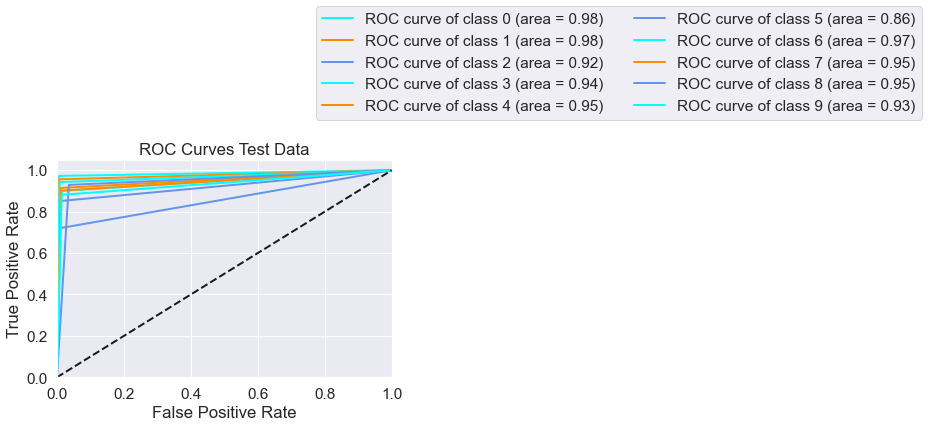

Auc Values of each classes ROC curve are written on graph
Macro Auc value:
0.9426926751382646


In [42]:
y_testb= label_binarize(y_test2, classes=[0, 1, 2,3,4,5,6,7,8,9]);
y_predb= label_binarize(y_pred2, classes=[0, 1, 2,3,4,5,6,7,8,9]);

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_testb[:,i], y_predb[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]));
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]);
mean_tpr /= 10;
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]);

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Test Data')
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)
plt.show()
print("Auc Values of each classes ROC curve are written on graph")
print("Macro Auc value:")
print(roc_auc["macro"]);
      

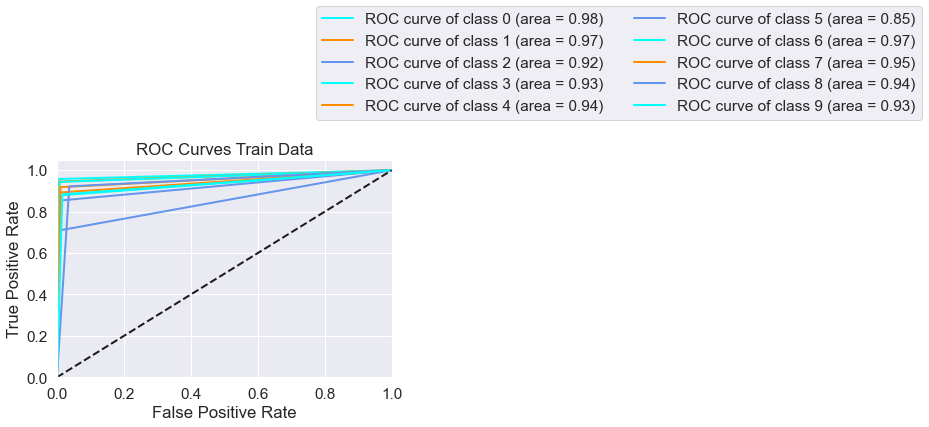

Auc Values of each classes ROC curve are written on graph
Macro Auc value:
0.9392242239150164


In [43]:
x_testb= label_binarize(x_test2, classes=[0, 1, 2,3,4,5,6,7,8,9]);
x_predb= label_binarize(x_pred2, classes=[0, 1, 2,3,4,5,6,7,8,9]);

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(x_testb[:,i], x_predb[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]));
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]);
mean_tpr /= 10;
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]);

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
            

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Train Data')
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)
plt.show()
print("Auc Values of each classes ROC curve are written on graph")
print("Macro Auc value:")
print(roc_auc["macro"]);

Yukardaki veriler göz önüne alınarak, modelin yaklaşık %90'lık başarımı elde ettiği gözlemlenmiştir.
Bunun yanında test sınıfı başarımı ile eğitim sınıfı başarımı arasında minimal bir fark olması, modelin eğitim verilerini ezberlemediğini yani modelde overfitting olmadığını ortaya koymuştur.

Bunun yanında test sınıfındaki başarımın eğitim sınıfındaki başarımdan küçük bir farkla daha yüksek olduğu gözlemlenmiştir.
Bunun nedeni çalışmada test ve eğitim sınıfları oluşturulurken, ortak bir veri setinin homojen dağılımla test ve train sınıfı olarak ayrılmasındansa, her bir veri sınıfı için farklı veri kaynakları kullanılmasından kaynaklı olabilir.